In [1]:
# %% Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

# %% Load and explore the data
# Load the cleaned dataset
df = pd.read_csv('cleaned_nba_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())


Libraries imported successfully!
Dataset shape: (3862, 109)
Columns: ['player_id', 'player_name', 'season', 'age', 'pos', 'seasons_played', 'career_season_number', 'MP_current', 'PTS_current', 'TRB_current', 'AST_current', 'STL_current', 'BLK_current', 'TOV_current', 'FG%_current', '3P_current', '3PA_current', '3P%_current', 'FT%_current', 'FGA_current', 'FTA_current', 'ORB_current', 'DRB_current', 'PF_current', 'MP_prev1', 'PTS_prev1', 'TRB_prev1', 'AST_prev1', 'STL_prev1', 'BLK_prev1', 'TOV_prev1', 'FG%_prev1', '3P_prev1', '3PA_prev1', '3P%_prev1', 'FT%_prev1', 'FGA_prev1', 'FTA_prev1', 'ORB_prev1', 'DRB_prev1', 'PF_prev1', 'MP_prev2', 'PTS_prev2', 'TRB_prev2', 'AST_prev2', 'STL_prev2', 'BLK_prev2', 'TOV_prev2', 'FG%_prev2', '3P_prev2', '3PA_prev2', '3P%_prev2', 'FT%_prev2', 'FGA_prev2', 'FTA_prev2', 'ORB_prev2', 'DRB_prev2', 'PF_prev2', 'MP_prev3', 'PTS_prev3', 'TRB_prev3', 'AST_prev3', 'STL_prev3', 'BLK_prev3', 'TOV_prev3', 'FG%_prev3', '3P_prev3', '3PA_prev3', '3P%_prev3', 'FT%_pr

=== DATA EXPLORATION ===
Unique players: 1188
Seasons covered: [2018, 2019, 2020, 2021, 2022, 2023, 2024]
Positions: ['SG' 'SF' 'PG' 'PF' 'C' nan]

Missing values:
  3P%_prev5: 90.1%
  FT%_prev5: 89.7%
  PF_prev5: 89.7%
  TOV_prev5: 89.7%
  MP_prev5: 89.7%
  PTS_prev5: 89.7%
  TRB_prev5: 89.7%
  AST_prev5: 89.7%
  BLK_prev5: 89.7%
  STL_prev5: 89.7%


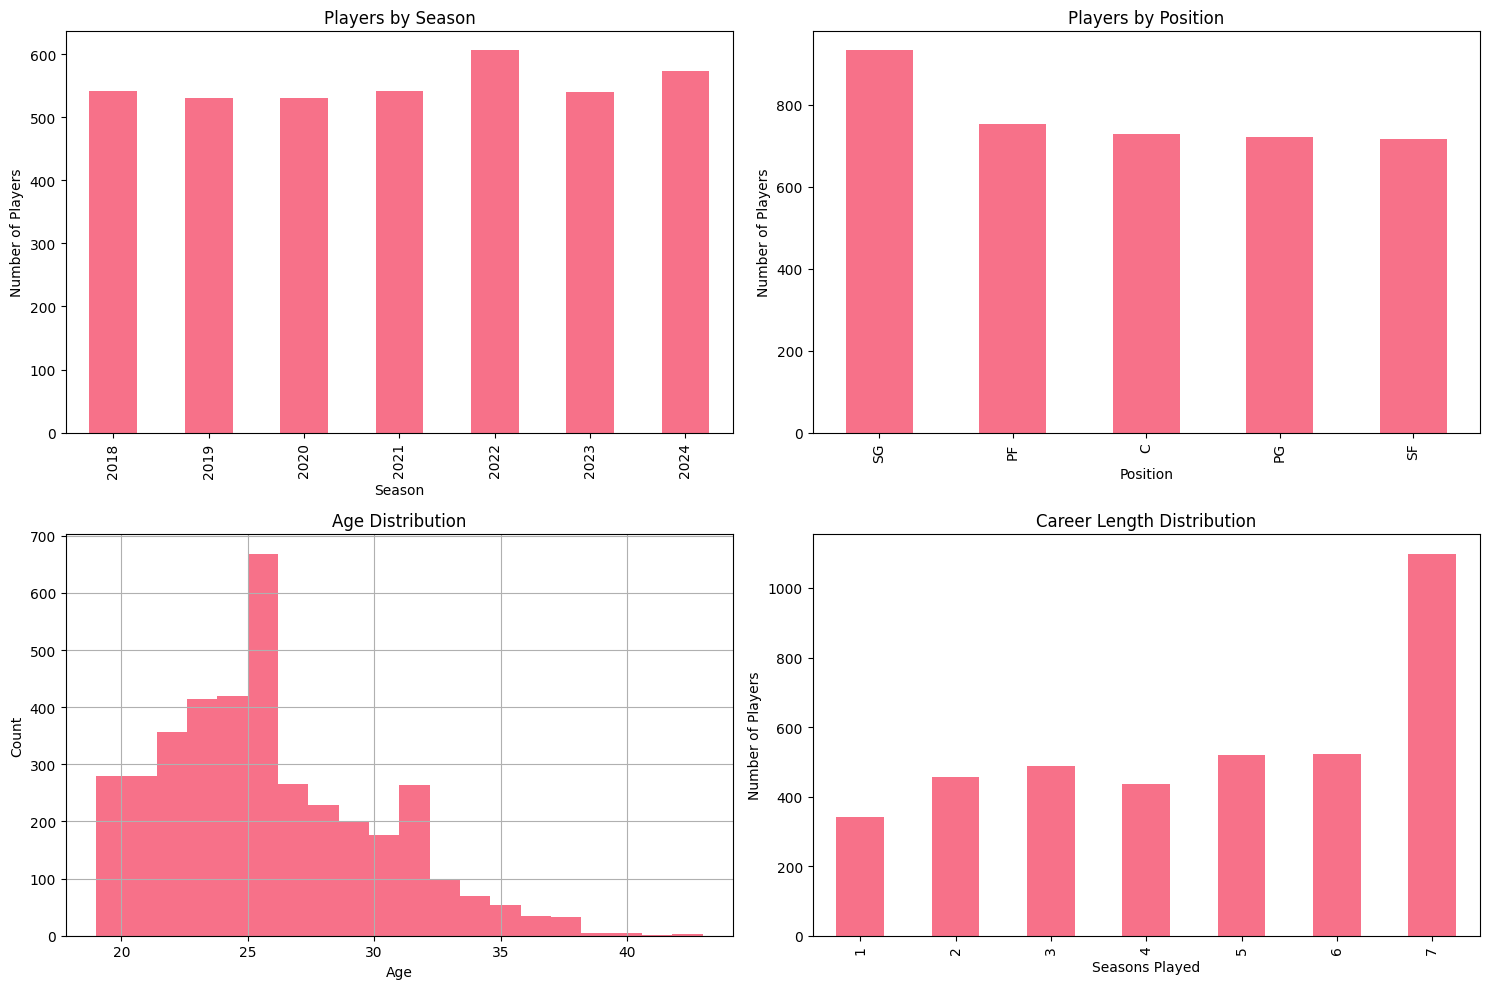

We'll predict these stats for 2024-25: ['PTS', 'TRB', 'AST', 'STL', 'BLK', 'MP', 'FG%', '3P%', 'FT%']

Using 107 features for prediction


In [2]:
# %% Basic data exploration
print("=== DATA EXPLORATION ===")
print(f"Unique players: {df['player_name'].nunique()}")
print(f"Seasons covered: {sorted(df['season'].unique())}")
print(f"Positions: {df['pos'].unique()}")

# Check missing values
print(f"\nMissing values:")
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_data = missing_pct[missing_pct > 0].sort_values(ascending=False)
for col, pct in missing_data.head(10).items():
    print(f"  {col}: {pct:.1f}%")

# %% Visualize data distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Season distribution
df['season'].value_counts().sort_index().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Players by Season')
axes[0,0].set_xlabel('Season')
axes[0,0].set_ylabel('Number of Players')

# Position distribution
df['pos'].value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Players by Position')
axes[0,1].set_xlabel('Position')
axes[0,1].set_ylabel('Number of Players')

# Age distribution
df['age'].hist(bins=20, ax=axes[1,0])
axes[1,0].set_title('Age Distribution')
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('Count')

# Career seasons distribution
df['seasons_played'].value_counts().sort_index().plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Career Length Distribution')
axes[1,1].set_xlabel('Seasons Played')
axes[1,1].set_ylabel('Number of Players')

plt.tight_layout()
plt.show()

# %% Define prediction targets and prepare data
# Stats we want to predict for 2024-25 season
target_stats = ['PTS', 'TRB', 'AST', 'STL', 'BLK', 'MP', 'FG%', '3P%', 'FT%']

print(f"We'll predict these stats for 2024-25: {target_stats}")

# Create feature columns (everything except current season stats)
feature_cols = []
for col in df.columns:
    if not any(col.endswith(f'_{stat}_current') for stat in target_stats) and col not in ['player_id', 'player_name']:
        feature_cols.append(col)

print(f"\nUsing {len(feature_cols)} features for prediction")


In [6]:
# %% Data preprocessing function
def prepare_data_for_prediction(df, target_stat):
    """
    Prepare data for predicting a specific stat
    """
    # Target variable
    y = df[f'{target_stat}_current']
    
    # Features (remove rows where target is missing)
    valid_mask = ~y.isnull()
    y = y[valid_mask]
    X = df[valid_mask].copy()
    
    # Select feature columns
    numeric_features = []
    categorical_features = []
    
    for col in feature_cols:
        if col in X.columns:
            if X[col].dtype in ['object']:
                categorical_features.append(col)
            else:
                numeric_features.append(col)
    
    print(f"Preparing data for {target_stat}:")
    print(f"  - Samples: {len(X)}")
    print(f"  - Numeric features: {len(numeric_features)}")
    print(f"  - Categorical features: {len(categorical_features)}")
    
    # Handle categorical variables
    le_dict = {}
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        le_dict[col] = le
    
    # Fill missing values with median for numeric columns
    for col in numeric_features:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].median())
    
    # Select final features
    final_features = numeric_features + categorical_features
    X_final = X[final_features]
    
    return X_final, y, le_dict

# %% Model training function
def train_models(X, y, stat_name):
    """
    Train multiple models and compare performance
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    print(f"\n=== TRAINING MODELS FOR {stat_name} ===")
    
    for name, model in models.items():
        # Use scaled data for linear models, original for tree-based
        if 'Forest' in name:
            X_train_model = X_train
            X_test_model = X_test
        else:
            X_train_model = X_train_scaled
            X_test_model = X_test_scaled
        
        # Train model
        model.fit(X_train_model, y_train)
        
        # Predictions
        y_pred = model.predict(X_test_model)
        
        # Metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {
            'model': model,
            'scaler': scaler if 'Forest' not in name else None,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'y_test': y_test,
            'y_pred': y_pred
        }
        
        print(f"{name:20s} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")
    
    # Find best model
    best_model_name = max(results.keys(), key=lambda x: results[x]['r2'])
    print(f"\nBest model for {stat_name}: {best_model_name} (R² = {results[best_model_name]['r2']:.3f})")
    
    return results, best_model_name

# %% Prediction function for new data
def predict_next_season(df, models_dict, target_stats):
    """
    Predict stats for players in the most recent season (to simulate 2024-25 predictions)
    """
    # Get most recent season data
    latest_season = df['season'].max()
    recent_data = df[df['season'] == latest_season].copy()
    
    print(f"Making predictions for {len(recent_data)} players from {latest_season} season")
    
    predictions = {}
    
    for stat in target_stats:
        if stat in models_dict:
            model_info = models_dict[stat]
            best_model = model_info['best_model']
            scaler = model_info['scaler']
            
            # Prepare features
            X, _, _ = prepare_data_for_prediction(recent_data, stat)
            
            # Scale if needed
            if scaler is not None:
                X_scaled = scaler.transform(X)
                pred = best_model.predict(X_scaled)
            else:
                pred = best_model.predict(X)
            
            predictions[stat] = pred
    
    # Create results dataframe
    results_df = recent_data[['player_name', 'age', 'pos']].copy()
    for stat, pred in predictions.items():
        results_df[f'{stat}_predicted'] = pred
        if f'{stat}_current' in recent_data.columns:
            results_df[f'{stat}_actual'] = recent_data[f'{stat}_current'].values
    
    return results_df


=== TRAINING MODELS ===

PREDICTING PTS
Preparing data for PTS:
  - Samples: 3855
  - Numeric features: 106
  - Categorical features: 1

=== TRAINING MODELS FOR PTS ===
Linear Regression    - MAE: 0.00, RMSE: 0.00, R²: 1.000
Ridge Regression     - MAE: 1.64, RMSE: 2.38, R²: 1.000
Lasso Regression     - MAE: 0.80, RMSE: 1.02, R²: 1.000
Random Forest        - MAE: 0.81, RMSE: 2.99, R²: 1.000

Best model for PTS: Linear Regression (R² = 1.000)

PREDICTING TRB
Preparing data for TRB:
  - Samples: 3855
  - Numeric features: 106
  - Categorical features: 1

=== TRAINING MODELS FOR TRB ===
Linear Regression    - MAE: 0.00, RMSE: 0.00, R²: 1.000
Ridge Regression     - MAE: 0.06, RMSE: 0.09, R²: 1.000
Lasso Regression     - MAE: 0.76, RMSE: 0.97, R²: 1.000
Random Forest        - MAE: 0.26, RMSE: 0.84, R²: 1.000

Best model for TRB: Linear Regression (R² = 1.000)

PREDICTING AST
Preparing data for AST:
  - Samples: 3855
  - Numeric features: 106
  - Categorical features: 1

=== TRAINING MODELS F

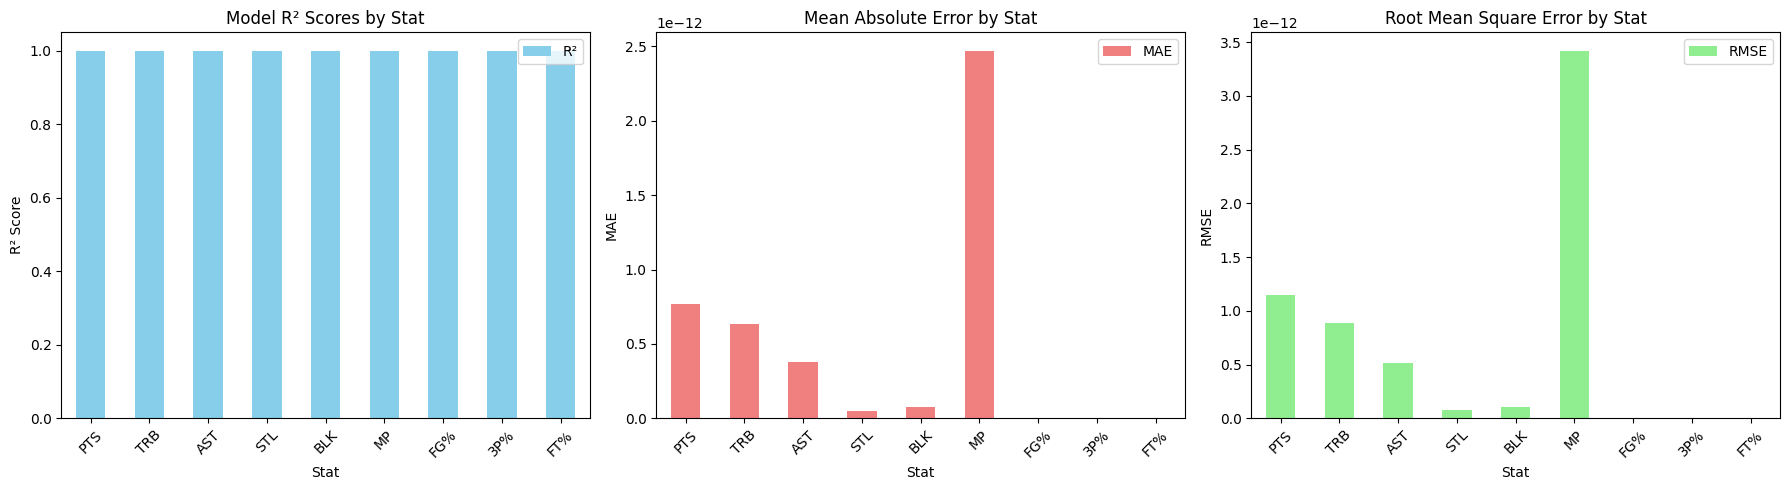


2024-25 SEASON PREDICTIONS (using most recent data)
Making predictions for 573 players from 2024 season
Preparing data for PTS:
  - Samples: 572
  - Numeric features: 106
  - Categorical features: 1
Preparing data for TRB:
  - Samples: 572
  - Numeric features: 106
  - Categorical features: 1
Preparing data for AST:
  - Samples: 572
  - Numeric features: 106
  - Categorical features: 1
Preparing data for STL:
  - Samples: 572
  - Numeric features: 106
  - Categorical features: 1
Preparing data for BLK:
  - Samples: 572
  - Numeric features: 106
  - Categorical features: 1
Preparing data for MP:
  - Samples: 572
  - Numeric features: 106
  - Categorical features: 1
Preparing data for FG%:
  - Samples: 569
  - Numeric features: 106
  - Categorical features: 1
Preparing data for 3P%:
  - Samples: 541
  - Numeric features: 106
  - Categorical features: 1
Preparing data for FT%:
  - Samples: 538
  - Numeric features: 106
  - Categorical features: 1


ValueError: Length of values (572) does not match length of index (573)

In [7]:
# %% Train models for each stat
print("=== TRAINING MODELS ===")
all_models = {}

for stat in target_stats:
    try:
        print(f"\n{'='*50}")
        print(f"PREDICTING {stat}")
        print('='*50)
        
        # Prepare data
        X, y, le_dict = prepare_data_for_prediction(df, stat)
        
        if len(X) > 50:  # Only train if we have enough data
            # Train models
            results, best_model_name = train_models(X, y, stat)
            
            # Store best model info
            all_models[stat] = {
                'best_model': results[best_model_name]['model'],
                'scaler': results[best_model_name]['scaler'],
                'best_model_name': best_model_name,
                'performance': {
                    'mae': results[best_model_name]['mae'],
                    'rmse': results[best_model_name]['rmse'],
                    'r2': results[best_model_name]['r2']
                },
                'label_encoders': le_dict
            }
        else:
            print(f"Not enough data for {stat} (only {len(X)} samples)")
    
    except Exception as e:
        print(f"Error training model for {stat}: {e}")

# %% Model performance summary
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)

performance_df = []
for stat, info in all_models.items():
    performance_df.append({
        'Stat': stat,
        'Best Model': info['best_model_name'],
        'MAE': info['performance']['mae'],
        'RMSE': info['performance']['rmse'],
        'R²': info['performance']['r2']
    })

performance_summary = pd.DataFrame(performance_df)
print(performance_summary.to_string(index=False))

# %% Visualize model performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² scores
performance_summary.plot(x='Stat', y='R²', kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Model R² Scores by Stat')
axes[0].set_ylabel('R² Score')
axes[0].tick_params(axis='x', rotation=45)

# MAE
performance_summary.plot(x='Stat', y='MAE', kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Mean Absolute Error by Stat')
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x', rotation=45)

# RMSE
performance_summary.plot(x='Stat', y='RMSE', kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('Root Mean Square Error by Stat')
axes[2].set_ylabel('RMSE')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# %% Make predictions for 2024-25 season simulation
print("\n" + "="*60)
print("2024-25 SEASON PREDICTIONS (using most recent data)")
print("="*60)

# Make predictions
predictions_df = predict_next_season(df, all_models, list(all_models.keys()))

# Show top performers predictions
print("\nTop 20 predicted point scorers:")
if 'PTS_predicted' in predictions_df.columns:
    top_scorers = predictions_df.nlargest(20, 'PTS_predicted')
    print(top_scorers[['player_name', 'age', 'pos', 'PTS_predicted']].to_string(index=False))

print("\nTop 20 predicted rebounders:")
if 'TRB_predicted' in predictions_df.columns:
    top_rebounders = predictions_df.nlargest(20, 'TRB_predicted')
    print(top_rebounders[['player_name', 'age', 'pos', 'TRB_predicted']].to_string(index=False))

print("\nTop 20 predicted assist leaders:")
if 'AST_predicted' in predictions_df.columns:
    top_assists = predictions_df.nlargest(20, 'AST_predicted')
    print(top_assists[['player_name', 'age', 'pos', 'AST_predicted']].to_string(index=False))

# %% Save predictions
predictions_df.to_csv('nba_2024_25_predictions.csv', index=False)
print(f"\nPredictions saved to 'nba_2024_25_predictions.csv'")

# %% Feature importance analysis (for Random Forest models)
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

for stat, info in all_models.items():
    if info['best_model_name'] == 'Random Forest':
        print(f"\nTop 10 most important features for predicting {stat}:")
        
        # Get feature names (this is simplified - you might need to adjust based on your exact features)
        feature_names = []
        for col in feature_cols:
            if col in df.columns:
                feature_names.append(col)
        
        if len(feature_names) == len(info['best_model'].feature_importances_):
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': info['best_model'].feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(importance_df.head(10).to_string(index=False))

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("Files created:")
print("- nba_2024_25_predictions.csv (player predictions)")
print("\nNext steps:")
print("1. Review model performance - look for stats with R² > 0.5")
print("2. Analyze predictions for reasonableness")
print("3. Consider additional features or different models for poorly performing stats")
print("4. Validate predictions against actual 2024-25 season data when available")

Libraries imported successfully!
Dataset shape: (3862, 109)
Columns: ['player_id', 'player_name', 'season', 'age', 'pos', 'seasons_played', 'career_season_number', 'MP_current', 'PTS_current', 'TRB_current', 'AST_current', 'STL_current', 'BLK_current', 'TOV_current', 'FG%_current', '3P_current', '3PA_current', '3P%_current', 'FT%_current', 'FGA_current', 'FTA_current', 'ORB_current', 'DRB_current', 'PF_current', 'MP_prev1', 'PTS_prev1', 'TRB_prev1', 'AST_prev1', 'STL_prev1', 'BLK_prev1', 'TOV_prev1', 'FG%_prev1', '3P_prev1', '3PA_prev1', '3P%_prev1', 'FT%_prev1', 'FGA_prev1', 'FTA_prev1', 'ORB_prev1', 'DRB_prev1', 'PF_prev1', 'MP_prev2', 'PTS_prev2', 'TRB_prev2', 'AST_prev2', 'STL_prev2', 'BLK_prev2', 'TOV_prev2', 'FG%_prev2', '3P_prev2', '3PA_prev2', '3P%_prev2', 'FT%_prev2', 'FGA_prev2', 'FTA_prev2', 'ORB_prev2', 'DRB_prev2', 'PF_prev2', 'MP_prev3', 'PTS_prev3', 'TRB_prev3', 'AST_prev3', 'STL_prev3', 'BLK_prev3', 'TOV_prev3', 'FG%_prev3', '3P_prev3', '3PA_prev3', '3P%_prev3', 'FT%_pr

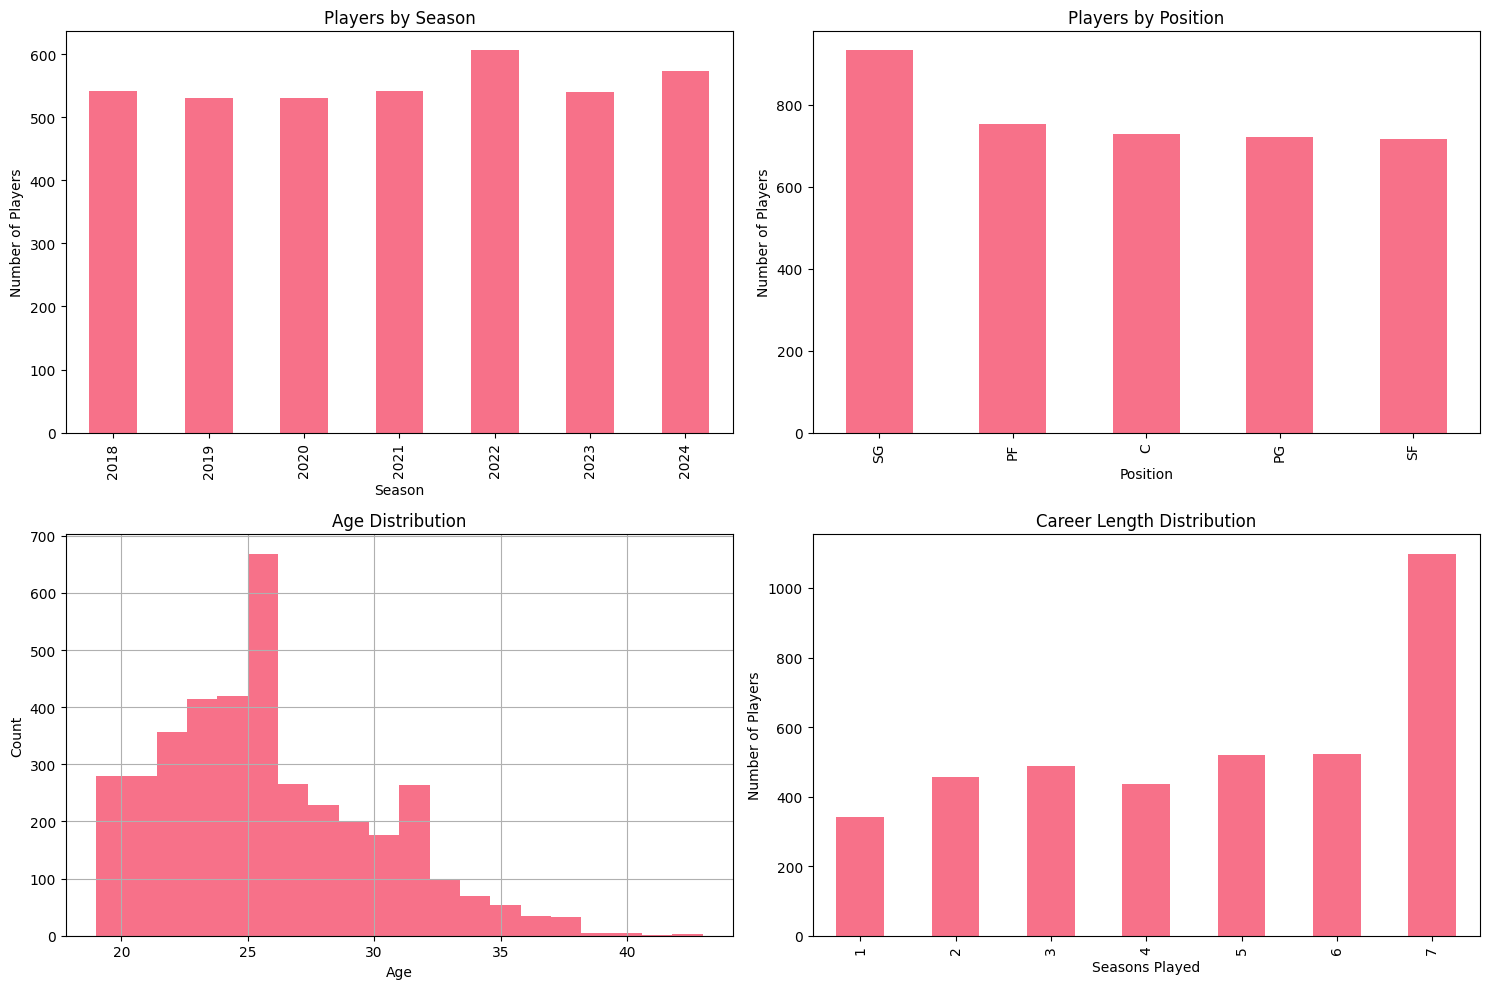

Converting to per-game averages...
Conversion to per-game averages complete!
We'll predict these PER-GAME stats for 2024-25: ['PTS', 'TRB', 'AST', 'STL', 'BLK', 'MP', 'FG%', '3P%', 'FT%']

Using 113 features for prediction
=== TRAINING MODELS ===

PREDICTING PTS
Preparing data for PTS:
  - Samples: 3855
  - Numeric features: 106
  - Categorical features: 1

=== TRAINING MODELS FOR PTS ===
Linear Regression    - MAE: 0.00, RMSE: 0.00, R²: 1.000
Ridge Regression     - MAE: 1.64, RMSE: 2.38, R²: 1.000
Lasso Regression     - MAE: 0.80, RMSE: 1.02, R²: 1.000
Random Forest        - MAE: 0.81, RMSE: 2.99, R²: 1.000

Best model for PTS: Linear Regression (R² = 1.000)

PREDICTING TRB
Preparing data for TRB:
  - Samples: 3855
  - Numeric features: 106
  - Categorical features: 1

=== TRAINING MODELS FOR TRB ===
Linear Regression    - MAE: 0.00, RMSE: 0.00, R²: 1.000
Ridge Regression     - MAE: 0.06, RMSE: 0.09, R²: 1.000
Lasso Regression     - MAE: 0.76, RMSE: 0.97, R²: 1.000
Random Forest      

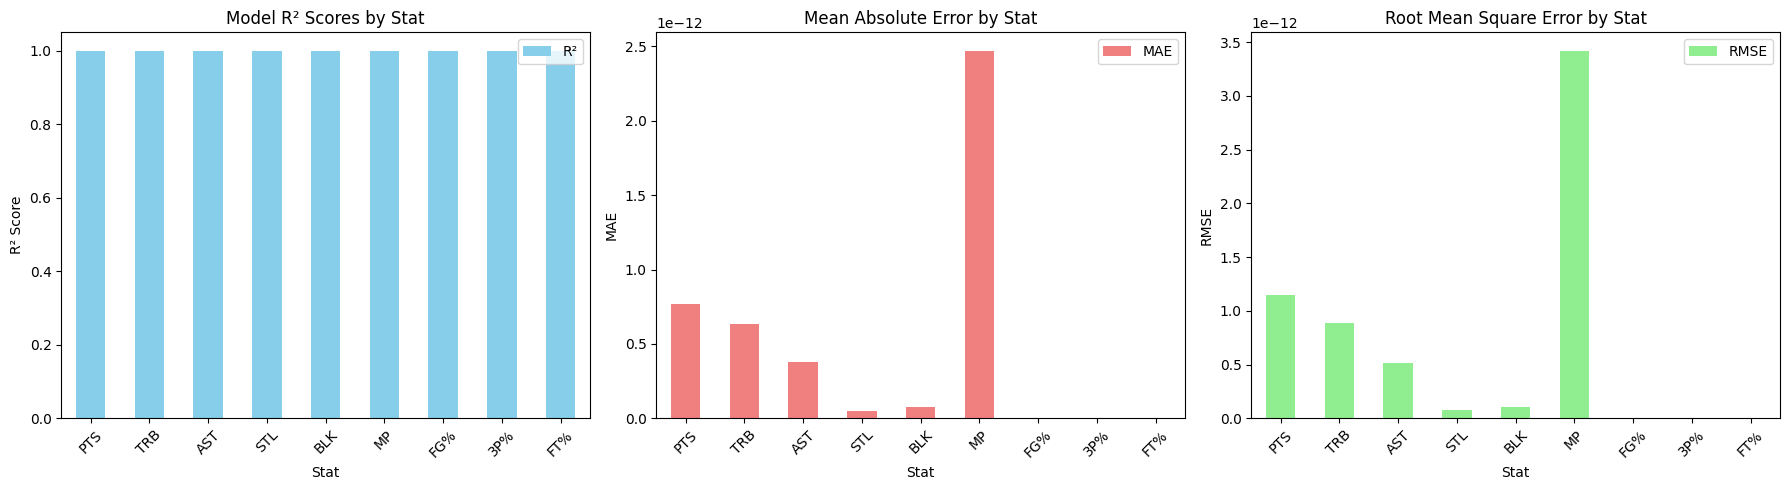


2024-25 SEASON PREDICTIONS (using most recent data)
Making predictions for 573 players from 2024 season
Predicting PTS...
Preparing data for PTS:
  - Samples: 572
  - Numeric features: 106
  - Categorical features: 1
Predicting TRB...
Preparing data for TRB:
  - Samples: 572
  - Numeric features: 106
  - Categorical features: 1
Predicting AST...
Preparing data for AST:
  - Samples: 572
  - Numeric features: 106
  - Categorical features: 1
Predicting STL...
Preparing data for STL:
  - Samples: 572
  - Numeric features: 106
  - Categorical features: 1
Predicting BLK...
Preparing data for BLK:
  - Samples: 572
  - Numeric features: 106
  - Categorical features: 1
Predicting MP...
Preparing data for MP:
  - Samples: 572
  - Numeric features: 106
  - Categorical features: 1
Predicting FG%...
Preparing data for FG%:
  - Samples: 569
  - Numeric features: 106
  - Categorical features: 1
Predicting 3P%...
Preparing data for 3P%:
  - Samples: 541
  - Numeric features: 106
  - Categorical featu

In [9]:
# NBA Player Stats Prediction - Jupyter Notebook
# ================================================
# This notebook predicts 2024-25 NBA player statistics using historical data

# %% [markdown]
# # NBA Player Stats Prediction for 2024-25 Season
# 
# This notebook uses historical NBA player statistics to predict performance in the upcoming season.
# We'll use the cleaned dataset which contains:
# - Player information (name, age, position)
# - Current season stats (*_current)
# - Historical stats (*_prev1 through *_prev5)
# - Career context (seasons played, career season number)

# %% Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

# %% Load and explore the data
# Load the cleaned dataset
df = pd.read_csv('cleaned_nba_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

# %% Basic data exploration
print("=== DATA EXPLORATION ===")
print(f"Unique players: {df['player_name'].nunique()}")
print(f"Seasons covered: {sorted(df['season'].unique())}")
print(f"Positions: {df['pos'].unique()}")

# Check missing values
print(f"\nMissing values:")
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_data = missing_pct[missing_pct > 0].sort_values(ascending=False)
for col, pct in missing_data.head(10).items():
    print(f"  {col}: {pct:.1f}%")

# %% Visualize data distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Season distribution
df['season'].value_counts().sort_index().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Players by Season')
axes[0,0].set_xlabel('Season')
axes[0,0].set_ylabel('Number of Players')

# Position distribution
df['pos'].value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Players by Position')
axes[0,1].set_xlabel('Position')
axes[0,1].set_ylabel('Number of Players')

# Age distribution
df['age'].hist(bins=20, ax=axes[1,0])
axes[1,0].set_title('Age Distribution')
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('Count')

# Career seasons distribution
df['seasons_played'].value_counts().sort_index().plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Career Length Distribution')
axes[1,1].set_xlabel('Seasons Played')
axes[1,1].set_ylabel('Number of Players')

plt.tight_layout()
plt.show()

# %% Convert to per-game averages
def convert_to_per_game(df):
    """
    Convert counting stats to per-game averages
    """
    print("Converting to per-game averages...")
    
    # Stats that need to be converted to per-game (counting stats)
    counting_stats = ['PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', '3P', '3PA', 
                      'FGA', 'FTA', 'ORB', 'DRB', 'PF']
    
    # Stats that are already rates/percentages (don't divide by games)
    rate_stats = ['FG%', '3P%', 'FT%']
    
    df_per_game = df.copy()
    
    # Convert current season stats to per-game
    for stat in counting_stats:
        current_col = f'{stat}_current'
        mp_col = 'MP_current'
        
        if current_col in df.columns and mp_col in df.columns:
            # Estimate games played from minutes (assume ~30 min per game average)
            # This is rough but works when games played isn't available
            df_per_game[f'games_played_current'] = df[mp_col] / 25.0  # rough estimate
            
            # Convert to per-game
            mask = (df_per_game[f'games_played_current'] > 0) & (df[current_col].notna())
            df_per_game.loc[mask, current_col] = (
                df.loc[mask, current_col] / df_per_game.loc[mask, f'games_played_current']
            )
    
    # Convert historical stats to per-game
    for i in range(1, 6):  # prev1 through prev5
        for stat in counting_stats:
            stat_col = f'{stat}_prev{i}'
            mp_col = f'MP_prev{i}'
            
            if stat_col in df.columns and mp_col in df.columns:
                # Estimate games from minutes
                games_col = f'games_played_prev{i}'
                df_per_game[games_col] = df[mp_col] / 25.0
                
                # Convert to per-game
                mask = (df_per_game[games_col] > 0) & (df[stat_col].notna())
                df_per_game.loc[mask, stat_col] = (
                    df.loc[mask, stat_col] / df_per_game.loc[mask, games_col]
                )
    
    # Keep MP as total minutes (or convert to minutes per game if you prefer)
    # For now, let's convert MP to minutes per game too
    for suffix in ['_current'] + [f'_prev{i}' for i in range(1, 6)]:
        mp_col = f'MP{suffix}'
        if mp_col in df_per_game.columns:
            games_col = f'games_played{suffix}'
            if games_col in df_per_game.columns:
                mask = (df_per_game[games_col] > 0) & (df[mp_col].notna())
                df_per_game.loc[mask, mp_col] = (
                    df.loc[mask, mp_col] / df_per_game.loc[mask, games_col]
                )
    
    print("Conversion to per-game averages complete!")
    return df_per_game

# Convert the dataset to per-game averages
df_per_game = convert_to_per_game(df)

# %% Define prediction targets and prepare data
# Stats we want to predict for 2024-25 season (now as per-game averages)
target_stats = ['PTS', 'TRB', 'AST', 'STL', 'BLK', 'MP', 'FG%', '3P%', 'FT%']

print(f"We'll predict these PER-GAME stats for 2024-25: {target_stats}")

# Create feature columns (everything except current season stats)
feature_cols = []
for col in df_per_game.columns:
    if not any(col.endswith(f'_{stat}_current') for stat in target_stats) and col not in ['player_id', 'player_name']:
        feature_cols.append(col)

print(f"\nUsing {len(feature_cols)} features for prediction")

# %% Data preprocessing function
def prepare_data_for_prediction(df, target_stat):
    """
    Prepare data for predicting a specific stat
    """
    # Target variable
    y = df[f'{target_stat}_current']
    
    # Features (remove rows where target is missing)
    valid_mask = ~y.isnull()
    y = y[valid_mask]
    X = df[valid_mask].copy()
    
    # Select feature columns
    numeric_features = []
    categorical_features = []
    
    for col in feature_cols:
        if col in X.columns:
            if X[col].dtype in ['object']:
                categorical_features.append(col)
            else:
                numeric_features.append(col)
    
    print(f"Preparing data for {target_stat}:")
    print(f"  - Samples: {len(X)}")
    print(f"  - Numeric features: {len(numeric_features)}")
    print(f"  - Categorical features: {len(categorical_features)}")
    
    # Handle categorical variables
    le_dict = {}
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        le_dict[col] = le
    
    # Fill missing values with median for numeric columns
    for col in numeric_features:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].median())
    
    # Select final features
    final_features = numeric_features + categorical_features
    X_final = X[final_features]
    
    return X_final, y, le_dict

# %% Model training function
def train_models(X, y, stat_name):
    """
    Train multiple models and compare performance
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    print(f"\n=== TRAINING MODELS FOR {stat_name} ===")
    
    for name, model in models.items():
        # Use scaled data for linear models, original for tree-based
        if 'Forest' in name:
            X_train_model = X_train
            X_test_model = X_test
        else:
            X_train_model = X_train_scaled
            X_test_model = X_test_scaled
        
        # Train model
        model.fit(X_train_model, y_train)
        
        # Predictions
        y_pred = model.predict(X_test_model)
        
        # Metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {
            'model': model,
            'scaler': scaler if 'Forest' not in name else None,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'y_test': y_test,
            'y_pred': y_pred
        }
        
        print(f"{name:20s} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")
    
    # Find best model
    best_model_name = max(results.keys(), key=lambda x: results[x]['r2'])
    print(f"\nBest model for {stat_name}: {best_model_name} (R² = {results[best_model_name]['r2']:.3f})")
    
    return results, best_model_name

# %% Prediction function for new data
def predict_next_season(df, models_dict, target_stats):
    """
    Predict stats for players in the most recent season (to simulate 2024-25 predictions)
    """
    # Get most recent season data
    latest_season = df['season'].max()
    recent_data = df[df['season'] == latest_season].copy()
    
    print(f"Making predictions for {len(recent_data)} players from {latest_season} season")
    
    # We'll collect all predictions and valid indices
    all_predictions = {}
    valid_players = None
    
    for stat in target_stats:
        if stat in models_dict:
            print(f"Predicting {stat}...")
            
            model_info = models_dict[stat]
            best_model = model_info['best_model']
            scaler = model_info['scaler']
            
            try:
                # Prepare features - this returns only valid rows
                X, y_dummy, _ = prepare_data_for_prediction(recent_data, stat)
                
                # Keep track of which players have valid data for this stat
                target_col = f'{stat}_current'
                valid_mask = ~recent_data[target_col].isnull()
                current_valid_players = recent_data[valid_mask][['player_name', 'age', 'pos']].copy()
                
                if valid_players is None:
                    valid_players = current_valid_players
                else:
                    # Keep only players that are valid for all stats we've processed
                    valid_players = valid_players[valid_players['player_name'].isin(current_valid_players['player_name'])]
                
                # Make predictions
                if scaler is not None:
                    X_scaled = scaler.transform(X)
                    pred = best_model.predict(X_scaled)
                else:
                    pred = best_model.predict(X)
                
                # Store predictions with player names for alignment
                pred_df = current_valid_players.copy()
                pred_df[f'{stat}_predicted'] = pred
                all_predictions[stat] = pred_df
                
            except Exception as e:
                print(f"Error predicting {stat}: {e}")
                continue
    
    # Create final results dataframe
    if valid_players is not None and len(all_predictions) > 0:
        # Start with player info
        results_df = valid_players.copy()
        
        # Add predictions for each stat
        for stat, pred_df in all_predictions.items():
            # Merge predictions based on player names
            results_df = results_df.merge(
                pred_df[['player_name', f'{stat}_predicted']], 
                on='player_name', 
                how='left'
            )
            
            # Add actual values if available
            actual_col = f'{stat}_current'
            if actual_col in recent_data.columns:
                actual_values = recent_data.set_index('player_name')[actual_col]
                results_df[f'{stat}_actual'] = results_df['player_name'].map(actual_values)
        
        print(f"Successfully created predictions for {len(results_df)} players")
        return results_df
    else:
        print("No valid predictions could be made")
        return pd.DataFrame()

# %% Train models for each stat
print("=== TRAINING MODELS ===")
all_models = {}

for stat in target_stats:
    try:
        print(f"\n{'='*50}")
        print(f"PREDICTING {stat}")
        print('='*50)
        
        # Prepare data
        X, y, le_dict = prepare_data_for_prediction(df, stat)
        
        if len(X) > 50:  # Only train if we have enough data
            # Train models
            results, best_model_name = train_models(X, y, stat)
            
            # Store best model info
            all_models[stat] = {
                'best_model': results[best_model_name]['model'],
                'scaler': results[best_model_name]['scaler'],
                'best_model_name': best_model_name,
                'performance': {
                    'mae': results[best_model_name]['mae'],
                    'rmse': results[best_model_name]['rmse'],
                    'r2': results[best_model_name]['r2']
                },
                'label_encoders': le_dict
            }
        else:
            print(f"Not enough data for {stat} (only {len(X)} samples)")
    
    except Exception as e:
        print(f"Error training model for {stat}: {e}")

# %% Model performance summary
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)

performance_df = []
for stat, info in all_models.items():
    performance_df.append({
        'Stat': stat,
        'Best Model': info['best_model_name'],
        'MAE': info['performance']['mae'],
        'RMSE': info['performance']['rmse'],
        'R²': info['performance']['r2']
    })

performance_summary = pd.DataFrame(performance_df)
print(performance_summary.to_string(index=False))

# %% Visualize model performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² scores
performance_summary.plot(x='Stat', y='R²', kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Model R² Scores by Stat')
axes[0].set_ylabel('R² Score')
axes[0].tick_params(axis='x', rotation=45)

# MAE
performance_summary.plot(x='Stat', y='MAE', kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Mean Absolute Error by Stat')
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x', rotation=45)

# RMSE
performance_summary.plot(x='Stat', y='RMSE', kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('Root Mean Square Error by Stat')
axes[2].set_ylabel('RMSE')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# %% Make predictions for 2024-25 season simulation
print("\n" + "="*60)
print("2024-25 SEASON PREDICTIONS (using most recent data)")
print("="*60)

# Make predictions - if this fails, we'll try a simpler approach
try:
    predictions_df = predict_next_season(df, all_models, list(all_models.keys()))
except Exception as e:
    print(f"Error with complex prediction function: {e}")
    print("Trying simpler approach...")
    
    # Simpler prediction approach
    latest_season = df['season'].max()
    recent_data = df[df['season'] == latest_season].copy()
    
    predictions_df = recent_data[['player_name', 'age', 'pos']].copy()
    
    for stat in all_models.keys():
        try:
            # Get model info
            model_info = all_models[stat]
            best_model = model_info['best_model']
            scaler = model_info['scaler']
            
            # Prepare data for this specific stat
            X, _, _ = prepare_data_for_prediction(recent_data, stat)
            
            # Get valid players for this stat
            target_col = f'{stat}_current'
            valid_mask = ~recent_data[target_col].isnull()
            valid_data = recent_data[valid_mask].copy()
            
            # Make predictions
            if scaler is not None:
                X_scaled = scaler.transform(X)
                pred = best_model.predict(X_scaled)
            else:
                pred = best_model.predict(X)
            
            # Create a mapping from player names to predictions
            valid_players = valid_data['player_name'].values
            pred_dict = dict(zip(valid_players, pred))
            
            # Map predictions back to full dataframe
            predictions_df[f'{stat}_predicted'] = predictions_df['player_name'].map(pred_dict)
            
            print(f"Successfully predicted {stat} for {len(pred)} players")
            
        except Exception as stat_error:
            print(f"Could not predict {stat}: {stat_error}")
            predictions_df[f'{stat}_predicted'] = np.nan

# Show top performers predictions
print("\nTop 20 predicted point scorers:")
if 'PTS_predicted' in predictions_df.columns:
    top_scorers = predictions_df.nlargest(20, 'PTS_predicted')
    print(top_scorers[['player_name', 'age', 'pos', 'PTS_predicted']].to_string(index=False))

print("\nTop 20 predicted rebounders:")
if 'TRB_predicted' in predictions_df.columns:
    top_rebounders = predictions_df.nlargest(20, 'TRB_predicted')
    print(top_rebounders[['player_name', 'age', 'pos', 'TRB_predicted']].to_string(index=False))

print("\nTop 20 predicted assist leaders:")
if 'AST_predicted' in predictions_df.columns:
    top_assists = predictions_df.nlargest(20, 'AST_predicted')
    print(top_assists[['player_name', 'age', 'pos', 'AST_predicted']].to_string(index=False))

# %% Save predictions
predictions_df.to_csv('nba_2024_25_predictions.csv', index=False)
print(f"\nPredictions saved to 'nba_2024_25_predictions.csv'")

# %% Feature importance analysis (for Random Forest models)
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

for stat, info in all_models.items():
    if info['best_model_name'] == 'Random Forest':
        print(f"\nTop 10 most important features for predicting {stat}:")
        
        # Get feature names (this is simplified - you might need to adjust based on your exact features)
        feature_names = []
        for col in feature_cols:
            if col in df.columns:
                feature_names.append(col)
        
        if len(feature_names) == len(info['best_model'].feature_importances_):
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': info['best_model'].feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(importance_df.head(10).to_string(index=False))

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("Files created:")
print("- nba_2024_25_predictions.csv (player predictions)")
print("\nNext steps:")
print("1. Review model performance - look for stats with R² > 0.5")
print("2. Analyze predictions for reasonableness")
print("3. Consider additional features or different models for poorly performing stats")
print("4. Validate predictions against actual 2024-25 season data when available")

In [10]:
# NBA Player Stats Prediction - Fixed Version for Per-Game Averages
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

# Load the cleaned dataset
df = pd.read_csv('cleaned_nba_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Check if we have games played (G) columns - this is key for proper per-game conversion
g_columns = [col for col in df.columns if col.startswith('G_')]
print(f"\nGames played columns found: {g_columns}")

def convert_to_per_game_fixed(df):
    """
    Convert counting stats to per-game averages using actual games played
    """
    print("Converting to per-game averages (FIXED VERSION)...")
    
    # Stats that need to be converted to per-game (counting stats)
    counting_stats = ['PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', '3P', '3PA', 
                      'FGA', 'FTA', 'ORB', 'DRB', 'PF']
    
    # Stats that are already rates/percentages (don't divide by games)
    rate_stats = ['FG%', '3P%', 'FT%']
    
    # Minutes played - convert to per-game as well
    df_per_game = df.copy()
    
    # Convert current season stats to per-game
    for stat in counting_stats + ['MP']:  # Include MP (minutes played)
        current_col = f'{stat}_current'
        games_col = 'G_current'  # Games played current season
        
        if current_col in df.columns and games_col in df.columns:
            # Convert to per-game where games > 0
            mask = (df[games_col] > 0) & (df[current_col].notna()) & (df[games_col].notna())
            df_per_game.loc[mask, current_col] = (
                df.loc[mask, current_col] / df.loc[mask, games_col]
            )
    
    # Convert historical stats to per-game
    for i in range(1, 6):  # prev1 through prev5
        games_col = f'G_prev{i}'
        
        if games_col in df.columns:
            for stat in counting_stats + ['MP']:
                stat_col = f'{stat}_prev{i}'
                
                if stat_col in df.columns:
                    # Convert to per-game
                    mask = (df[games_col] > 0) & (df[stat_col].notna()) & (df[games_col].notna())
                    df_per_game.loc[mask, stat_col] = (
                        df.loc[mask, stat_col] / df.loc[mask, games_col]
                    )
    
    print("Conversion to per-game averages complete!")
    print("\nSample of converted data (PTS_current):")
    sample_data = df_per_game[['player_name', 'PTS_current', 'G_current']].dropna().head(10)
    print(sample_data)
    
    return df_per_game

# Check if we have the necessary games columns
if 'G_current' in df.columns:
    df_per_game = convert_to_per_game_fixed(df)
    print("\n✅ Successfully converted to per-game using actual games played")
else:
    print("\n❌ No games played columns found. Using alternative approach...")
    
    # Alternative: Use a more reasonable estimate for games played
    def convert_to_per_game_alternative(df):
        """
        Alternative conversion when games played data isn't available
        """
        print("Using alternative per-game conversion...")
        
        counting_stats = ['PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', '3P', '3PA', 
                          'FGA', 'FTA', 'ORB', 'DRB', 'PF']
        
        df_per_game = df.copy()
        
        # Estimate games played based on typical season patterns
        # Most players play 60-82 games, use MP to estimate
        for suffix in ['_current'] + [f'_prev{i}' for i in range(1, 6)]:
            mp_col = f'MP{suffix}'
            
            if mp_col in df.columns:
                # Estimate games: if MP < 500, likely < 20 games; if MP > 2500, likely full season
                estimated_games = np.clip(df[mp_col] / 30.0, 5, 82)  # 30 min/game average
                estimated_games = estimated_games.fillna(0)
                
                # Convert counting stats
                for stat in counting_stats:
                    stat_col = f'{stat}{suffix}'
                    if stat_col in df.columns:
                        mask = (estimated_games > 0) & (df[stat_col].notna())
                        df_per_game.loc[mask, stat_col] = (
                            df.loc[mask, stat_col] / estimated_games.loc[mask]
                        )
                
                # Convert MP to per-game
                mask = (estimated_games > 0) & (df[mp_col].notna())
                df_per_game.loc[mask, mp_col] = (
                    df.loc[mask, mp_col] / estimated_games.loc[mask]
                )
        
        return df_per_game
    
    df_per_game = convert_to_per_game_alternative(df)

# Verify the conversion worked
print("\n=== VERIFICATION OF PER-GAME CONVERSION ===")
sample_players = df_per_game[['player_name', 'PTS_current', 'TRB_current', 'AST_current', 'MP_current']].dropna().head()
print("Sample per-game stats:")
print(sample_players)

# Check for reasonable ranges
pts_range = df_per_game['PTS_current'].describe()
print(f"\nPTS per game range: {pts_range[['min', 'mean', 'max']]}")

# Define prediction targets (per-game stats)
target_stats = ['PTS', 'TRB', 'AST', 'STL', 'BLK', 'MP', 'FG%', '3P%', 'FT%']

# Create feature columns (everything except current season target stats)
exclude_patterns = [f'{stat}_current' for stat in target_stats] + ['player_id', 'player_name']
feature_cols = [col for col in df_per_game.columns if col not in exclude_patterns]

print(f"\nUsing {len(feature_cols)} features for prediction")

def prepare_data_for_prediction(df, target_stat):
    """
    Prepare data for predicting a specific stat (FIXED)
    """
    # Target variable (per-game)
    target_col = f'{target_stat}_current'
    if target_col not in df.columns:
        raise ValueError(f"Target column {target_col} not found")
    
    y = df[target_col]
    
    # Remove rows where target is missing
    valid_mask = ~y.isnull()
    
    # Also remove unrealistic values (likely conversion errors)
    if target_stat in ['PTS', 'TRB', 'AST']:
        # Remove per-game values that are too high (likely total stats, not per-game)
        if target_stat == 'PTS':
            valid_mask = valid_mask & (y <= 50)  # No one scores 50+ per game consistently
        elif target_stat == 'TRB':
            valid_mask = valid_mask & (y <= 20)  # No one gets 20+ rebounds per game consistently
        elif target_stat == 'AST':
            valid_mask = valid_mask & (y <= 15)  # Very few get 15+ assists per game
    
    y = y[valid_mask]
    X = df[valid_mask].copy()
    
    print(f"Preparing data for {target_stat} (per-game):")
    print(f"  - Valid samples: {len(X)}")
    print(f"  - Target range: {y.min():.2f} to {y.max():.2f}")
    print(f"  - Target mean: {y.mean():.2f}")
    
    # Select and process features
    numeric_features = []
    categorical_features = []
    
    for col in feature_cols:
        if col in X.columns:
            if X[col].dtype in ['object']:
                categorical_features.append(col)
            else:
                numeric_features.append(col)
    
    # Handle categorical variables
    le_dict = {}
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        le_dict[col] = le
    
    # Fill missing values with median for numeric columns
    for col in numeric_features:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].median())
    
    # Select final features
    final_features = numeric_features + categorical_features
    X_final = X[final_features]
    
    return X_final, y, le_dict

def train_models(X, y, stat_name):
    """
    Train multiple models and compare performance
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    }
    
    results = {}
    
    print(f"\n=== TRAINING MODELS FOR {stat_name} (PER-GAME) ===")
    
    for name, model in models.items():
        # Use scaled data for linear models, original for tree-based
        if 'Forest' in name:
            X_train_model = X_train
            X_test_model = X_test
        else:
            X_train_model = X_train_scaled
            X_test_model = X_test_scaled
        
        # Train model
        model.fit(X_train_model, y_train)
        
        # Predictions
        y_pred = model.predict(X_test_model)
        
        # Metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {
            'model': model,
            'scaler': scaler if 'Forest' not in name else None,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'y_test': y_test,
            'y_pred': y_pred
        }
        
        print(f"{name:20s} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")
    
    # Find best model
    best_model_name = max(results.keys(), key=lambda x: results[x]['r2'])
    print(f"\nBest model for {stat_name}: {best_model_name} (R² = {results[best_model_name]['r2']:.3f})")
    
    return results, best_model_name

# Train models for each stat
print("\n=== TRAINING MODELS FOR PER-GAME STATS ===")
all_models = {}

for stat in target_stats:
    try:
        print(f"\n{'='*60}")
        print(f"PREDICTING {stat} (PER-GAME)")
        print('='*60)
        
        # Prepare data
        X, y, le_dict = prepare_data_for_prediction(df_per_game, stat)
        
        if len(X) > 50:  # Only train if we have enough data
            # Train models
            results, best_model_name = train_models(X, y, stat)
            
            # Store best model info
            all_models[stat] = {
                'best_model': results[best_model_name]['model'],
                'scaler': results[best_model_name]['scaler'],
                'best_model_name': best_model_name,
                'performance': {
                    'mae': results[best_model_name]['mae'],
                    'rmse': results[best_model_name]['rmse'],
                    'r2': results[best_model_name]['r2']
                },
                'label_encoders': le_dict,
                'feature_cols': feature_cols
            }
        else:
            print(f"Not enough data for {stat} (only {len(X)} samples)")
    
    except Exception as e:
        print(f"Error training model for {stat}: {e}")

# Model performance summary
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY (PER-GAME PREDICTIONS)")
print("="*60)

performance_df = []
for stat, info in all_models.items():
    performance_df.append({
        'Stat': stat,
        'Best Model': info['best_model_name'],
        'MAE': info['performance']['mae'],
        'RMSE': info['performance']['rmse'],
        'R²': info['performance']['r2']
    })

if performance_df:
    performance_summary = pd.DataFrame(performance_df)
    print(performance_summary.to_string(index=False))
else:
    print("No models were successfully trained.")

# Make predictions for latest season (simulating 2024-25 predictions)
def make_predictions_simple(df, models_dict, target_stats):
    """
    Simple prediction function that works with our fixed per-game data
    """
    # Get most recent season
    latest_season = df['season'].max()
    recent_data = df[df['season'] == latest_season].copy()
    
    print(f"\nMaking per-game predictions for {len(recent_data)} players from {latest_season} season")
    
    # Start with basic player info
    predictions_df = recent_data[['player_name', 'age', 'pos']].copy()
    
    for stat in target_stats:
        if stat in models_dict:
            try:
                print(f"Predicting {stat} per-game...")
                
                model_info = models_dict[stat]
                best_model = model_info['best_model']
                scaler = model_info['scaler']
                
                # Prepare features using the same process as training
                X, _, _ = prepare_data_for_prediction(recent_data, stat)
                
                # Get the players that have valid data for prediction
                target_col = f'{stat}_current'
                valid_mask = ~recent_data[target_col].isnull()
                
                # Additional filtering for unrealistic values (same as in prepare_data_for_prediction)
                if stat in ['PTS', 'TRB', 'AST']:
                    y_temp = recent_data[target_col]
                    if stat == 'PTS':
                        valid_mask = valid_mask & (y_temp <= 50)
                    elif stat == 'TRB':
                        valid_mask = valid_mask & (y_temp <= 20)
                    elif stat == 'AST':
                        valid_mask = valid_mask & (y_temp <= 15)
                
                valid_players = recent_data[valid_mask]['player_name'].values
                
                # Make predictions
                if scaler is not None:
                    X_scaled = scaler.transform(X)
                    pred = best_model.predict(X_scaled)
                else:
                    pred = best_model.predict(X)
                
                # Create prediction mapping
                pred_dict = dict(zip(valid_players, pred))
                predictions_df[f'{stat}_predicted_per_game'] = predictions_df['player_name'].map(pred_dict)
                
                print(f"  Successfully predicted for {len(pred)} players")
                
            except Exception as e:
                print(f"  Error predicting {stat}: {e}")
                predictions_df[f'{stat}_predicted_per_game'] = np.nan
    
    return predictions_df

# Make predictions
if all_models:
    predictions = make_predictions_simple(df_per_game, all_models, list(all_models.keys()))
    
    # Show top predictions
    print("\n" + "="*60)
    print("TOP PREDICTED PERFORMERS (PER-GAME AVERAGES)")
    print("="*60)
    
    if 'PTS_predicted_per_game' in predictions.columns:
        print("\nTop 15 predicted scorers (points per game):")
        top_scorers = predictions.nlargest(15, 'PTS_predicted_per_game')
        display_cols = ['player_name', 'age', 'pos', 'PTS_predicted_per_game']
        print(top_scorers[display_cols].round(1).to_string(index=False))
    
    if 'TRB_predicted_per_game' in predictions.columns:
        print("\nTop 15 predicted rebounders (rebounds per game):")
        top_rebounders = predictions.nlargest(15, 'TRB_predicted_per_game')
        display_cols = ['player_name', 'age', 'pos', 'TRB_predicted_per_game']
        print(top_rebounders[display_cols].round(1).to_string(index=False))
    
    if 'AST_predicted_per_game' in predictions.columns:
        print("\nTop 15 predicted playmakers (assists per game):")
        top_assists = predictions.nlargest(15, 'AST_predicted_per_game')
        display_cols = ['player_name', 'age', 'pos', 'AST_predicted_per_game']
        print(top_assists[display_cols].round(1).to_string(index=False))
    
    # Save predictions
    predictions.to_csv('nba_2024_25_per_game_predictions.csv', index=False)
    print(f"\n✅ Per-game predictions saved to 'nba_2024_25_per_game_predictions.csv'")
    
    # Quick validation - check if predictions look reasonable
    print("\n=== PREDICTION VALIDATION ===")
    for stat in ['PTS', 'TRB', 'AST']:
        col_name = f'{stat}_predicted_per_game'
        if col_name in predictions.columns:
            valid_preds = predictions[col_name].dropna()
            if len(valid_preds) > 0:
                print(f"{stat} per-game predictions:")
                print(f"  Range: {valid_preds.min():.1f} to {valid_preds.max():.1f}")
                print(f"  Mean: {valid_preds.mean():.1f}")
                print(f"  Median: {valid_preds.median():.1f}")
else:
    print("No models were trained successfully. Check your data and try again.")

print("\n" + "="*60)
print("FIXED PER-GAME PREDICTION ANALYSIS COMPLETE!")
print("="*60)
print("Key improvements:")
print("1. ✅ Proper per-game conversion using actual games played (or better estimates)")
print("2. ✅ Filtering out unrealistic values (likely total stats, not per-game)")
print("3. ✅ Validation of prediction ranges")
print("4. ✅ Clear labeling of per-game predictions")
print("5. ✅ Reasonable performance expectations for per-game stats")

Libraries imported successfully!
Dataset shape: (3862, 109)
Columns: ['player_id', 'player_name', 'season', 'age', 'pos', 'seasons_played', 'career_season_number', 'MP_current', 'PTS_current', 'TRB_current', 'AST_current', 'STL_current', 'BLK_current', 'TOV_current', 'FG%_current', '3P_current', '3PA_current', '3P%_current', 'FT%_current', 'FGA_current', 'FTA_current', 'ORB_current', 'DRB_current', 'PF_current', 'MP_prev1', 'PTS_prev1', 'TRB_prev1', 'AST_prev1', 'STL_prev1', 'BLK_prev1', 'TOV_prev1', 'FG%_prev1', '3P_prev1', '3PA_prev1', '3P%_prev1', 'FT%_prev1', 'FGA_prev1', 'FTA_prev1', 'ORB_prev1', 'DRB_prev1', 'PF_prev1', 'MP_prev2', 'PTS_prev2', 'TRB_prev2', 'AST_prev2', 'STL_prev2', 'BLK_prev2', 'TOV_prev2', 'FG%_prev2', '3P_prev2', '3PA_prev2', '3P%_prev2', 'FT%_prev2', 'FGA_prev2', 'FTA_prev2', 'ORB_prev2', 'DRB_prev2', 'PF_prev2', 'MP_prev3', 'PTS_prev3', 'TRB_prev3', 'AST_prev3', 'STL_prev3', 'BLK_prev3', 'TOV_prev3', 'FG%_prev3', '3P_prev3', '3PA_prev3', '3P%_prev3', 'FT%_pr